# Studying the influence of atmospheric circulation on upper tropospheric humidity

### Quality question:
 - __Do upper tropospheric humidity product represent the observed variability under different large-scale regimes in the tropics?__


The atmospheric circulation is the large-scale movement of air through the Earth's atmosphere, driven by the uneven heating of the planet's surface by the sun. This circulation is responsible for distributing heat and moisture around the globe, shaping weather patterns and climate.
The movement of the air masses influences the distribution of humidity in the upper troposphere. In regions where air rises, such as the  Inter Tropical Convergence Zone, moisture from the lower atmosphere is transported upward, increasing humidity in the upper troposphere.
Conversely, in regions where air sinks, the upper troposphere becomes drier.


This analysis is performed using the dataset [__Upper tropospheric humidity gridded data from 1999 to present derived from satellite observations__](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-upper-troposphere-humidity) provided by the Climate Data Store (CDS). This dataset provides the relative humidity in the upper troposphere column (500 hPa - 200 hPa) with an horizontal resolution of 1.0° x 1.0°. The data records are retrieved from the 183.31±1 GHz channel of the Advanced Microwave Sounding Unit-B (AMSU-B) and the Microwave Humidity Sounder (MHS) on board the NOAA- and MetOp- satellite series.


This notebook aims to examine the dependency of upper tropospheric humidity on the global atmospheric circulation. Specifically, it seeks to verify if the UTH dataset can reproduce this dependency in agreement with [[1]](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2010JD014287). The analysis will compare the dataset's findings with established results to ensure consistency and reliability in representing the atmospheric dynamics.


<!--
The dataset "Upper tropospheric humidity gridded data from 1999 to present derived from satellite observations" provides the relative humidity in the upper troposphere column (500 hPa - 200 hPa) with an horizontal resolution of 1.0° x 1.0°. The data records are retrieved from the 183.31±1 GHz channel of the Advanced Microwave Sounding Unit-B (AMSU-B) and the Microwave Humidity Sounder (MHS) on board the NOAA- and MetOp- satellite series.

The following notebook addresses how well this dataset reproduce the dependency over different regimes of atmospheric circulation in the tropics.
The regimes of atmospheric circulations are identified by different vertical velocities at 500 hPa, called $\omega_{500}$. 
The Upper Tropospheric Humidity (UTH) is obtained from MHS on MetOp-A, available in the product __Upper tropospheric humidity gridded data from 1999 to present derived from satellite observations__. The vertical velocity is obtained from ERA5 reanalysis. Both products are available on the Copernicus Data Store (CDS).

-->


## Quality assessment statement 

These are the key outcomes of this assessment

- The UTH presents the transition between ascending and subsiding motions, showing the influence of atmospheric circulation on humidity levels. Ascending motions tend to moisten the upper troposphere, whereas subsiding motions lead to a humidity decrease.

- Ascending motion exhibits a constant UTH of about 20%, while regions with strong convection have a UTH of approximately 50%, with a sharp transition between these two regimes. These results align with Fig. 1 of [[1]](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2010JD014287), and they confirm that the CDS product of upper tropospheric humidity accurately represents the observed variability under different large-scale regimes.

## Methodology

The upper tropospheric humidity (UTH) data over the tropics is downloaded for the year 2007.
The atmospheric circulation is quantified by the vertical velocity at 500 hPa ($\omega_{500}$), which is obtained from the ERA5 reanalysis for the same region and period.


Both variables are averaged monthly to smooth out short-term fluctuations caused by convection. The ERA5 data resolution is then reduced to 1 degree to match the resolution of the UTH data. After collocating the monthly values at this resolution, the UTH values are categorized into bins based on the vertical velocities. The distribution of UTH within each bin is presented as a boxplot profile, providing a clear visualization of how UTH varies with changes in vertical velocity. 
<!--This method offers an in-depth analysis of the relationship between atmospheric circulation and upper tropospheric humidity.

Both variables are averaged monthly to smooth out short-term fluctuations given by convection. Then, the ERA5 data resolution is reduced to 1 degree in order to match with the resolution of the UTH data. Monthly values at 1 degree resolution are collocated, and then, values of UTH are then categorized into bins based on the vertical velocities. The distribution of UTH within each bin is presented as a boxplot profile, providing a clear visualization of how humidity varies with changes in vertical velocity. 
-->


The analysis comprises the following steps:

__1. [Choose the parameters to use and setup code](#Choose-the-parameters-to-use-and-setup-code)__
 - Import the relevant packages. Define the parameters of the analysis and set the dataset requests

__2. [Download the datasets](#Download-the-datasets)__
 - Download the variables of interest: Upper Tropospheric Humidity is obtained from MHS observation onboard MetOp-A, vertical velocity at 500 hPa is obtained from ERA5 reanalysis. Both datasets are downloaded from the CDS.

__3.[Collocate the dataset](#Collocate-the-dataset)__
 -  The datasets are monthly averaged.
 -  ERA5 vertical velocity is regridded in order to align with the resolution of UTH.
 -  UTH and vertical velocity are stored in a pandas dataframe.
   
__4. [Results](#Results)__
 - The composite profile of upper tropospheric humidity (UTH) is shown as a function of vertical velocity. The final results are compared with the appropriate reference to assess the reliability of the dataset.



## Analysis and Results

### Choose the parameters to use and setup code

#### Import packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from c3s_eqc_automatic_quality_control import download

plt.style.use("seaborn-v0_8-notebook")

import os
os.environ["CDSAPI_RC"] = os.path.expanduser("~/mandorli_giulio/.cdsapirc")

#### Define parameters

In [2]:
# Time
start = "2007-01"
stop = "2007-12"

# Region: Degree range has to be integers because UTH has a resolution of 1x1
lat_min = -30
lat_max = 30
lon_min = 0
lon_max = 360
assert (isinstance(coord, int) for coord in (lat_min, lat_max, lon_min, lon_max))
assert 0 <= lon_min <= lon_max <= 360

#### Set the data request

In [3]:
chunks = {"year": 1, "month": 1}

collection_id_uth = "satellite-upper-troposphere-humidity"
request_uth = {
    "variable": "all",
    "sensor_on_satellite": "mhs_on_metop_a",
    "area": [lat_min, lon_min, lat_max, lon_max],
}


collection_id_omega500 = "reanalysis-era5-pressure-levels"
request_omega500 = {
    "product_type": "ensemble_mean",
    "variable": "vertical_velocity",
    "pressure_level": "500",
    'time': [ f'{h}:00' for h in range(0, 24, 3) ],
    "area": [lat_min, lon_min, lat_max-0.01, lon_max],    
}


### Download the datasets

#### Download UTH

In [4]:
ds_uth = download.download_and_transform(
    collection_id_uth,
    download.update_request_date(request_uth, start, stop, stringify_dates=True),
    chunks=chunks,
)

100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


#### Download OMEGA 500

In [5]:
ds_omega500 = download.download_and_transform(
    collection_id_omega500,
    download.update_request_date(request_omega500, start, stop, stringify_dates=True),
    chunks=chunks,
)

100%|██████████| 12/12 [00:01<00:00,  9.84it/s]


### Collocate the dataset at the monthly time scale

In [6]:
ds_omega500 = ds_omega500.drop_vars("time").rename(forecast_reference_time="time")

ds_uth_monthly = ds_uth.resample(time='1ME').mean()
ds_omega500_monthly = ds_omega500.resample(time='1ME').mean().coarsen(latitude=2, longitude=2).mean()

# Units
with xr.set_options(keep_attrs=True):
    ds_omega500_monthly["w"] *= 24 * 36  # from Pa/s to hPa / day
ds_omega500_monthly.attrs["units"] = "hPa / day"

#### Make 1D dataframe

In [7]:
ds_omega500_monthly = ds_omega500_monthly.reindex(latitude=list(reversed(ds_omega500_monthly.latitude)))
series = {}
for da in [ds_uth_monthly["uth_mean_ascend_descend"], ds_omega500_monthly["w"]]:
    series[da.name] = (
        da.sortby(list(da.dims))
        .stack(index=sorted(da.dims))
        .to_series()
        .reset_index(drop=True)
    )
df = pd.DataFrame(series)

### Results

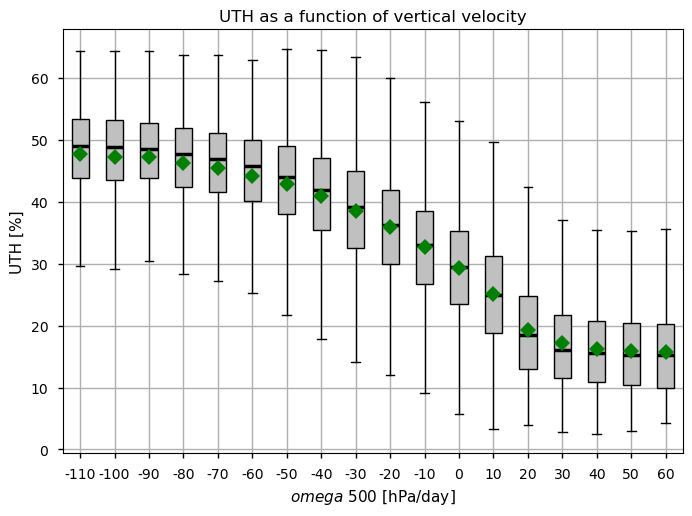

In [8]:
bin_edges = range(-115, 66, 10)
bin_labels = pd.Series(bin_edges).rolling(2).mean()[1:]
grouper = pd.cut(df["w"], bin_edges)
ax = df.groupby(grouper, observed=False).boxplot(
    subplots=False,
    column="uth_mean_ascend_descend",
    showfliers=False,
    patch_artist=True,
    showmeans=True,
    medianprops={"linewidth": 2.5, "color": "k"},
    meanprops={
        "marker": "D",
        "markeredgecolor": "black",
        "markerfacecolor": "green",
        "markersize": 8,
    },
    whiskerprops={"color": "k"},
    boxprops={"color": "k", "facecolor": "silver"},
    xlabel="$omega$ 500 [hPa/day]",
    ylabel="UTH [%]",
    grid=True,
)
ax.set_title("UTH as a function of vertical velocity")
_ = ax.set_xticklabels(bin_labels.astype(int))


_This plot shows the distribution of UTH for different circulation regimes. The gray boxes represent the interquartiles, black lines show the median, and green rhombs show the mean of the UTH for each specific bin._


The Upper tropospheric humidity is large in regions with negative values of vertical velocities. Negative values of vertical velocities are associated to deep convective regions like the ITCZ, that humidifies the troposphere by moving upward the moisture from the boundary layer. 

The Upper tropospheric humidity is small in regions with negative values of vertical velocities, named subsidence regions. They are mainly in the subtropics and they include deserts and oceanic areas with high pressure. In subsidence regions, the air sinks and warms adiabatically without changing its water vapour content, thus the relative humidity decreases. 


The results are in agreement with Fig.1 of [[1]](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2010JD014287), which compare the retrieved monthly UTH from NOAA-16 to the vertical velocity.
In both cases, the UTH shows a sharp transition from convergence regions to subsidence regions. The UTH value remains stable at around 20% over regions where the vertical velocity exceeds 30 hPa/day. The discrepancy between the present results and the reference lies within the UTH distribution and can be explained by the factors outlined below.

The UTH reaches a maximum value of approximately 45-50% when upward motions reach -70 hPa/day. The reference reports slightly lower values, which still fall within the UTH distribution observed in this study. The discrepancies between these results and those presented in [[1]](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2010JD014287) can arise from the following reasons:
- The retrieval method used is similar; however, the tuned parameters of the equation $$\text{ln}(UTH) = a + b \cdot T_B$$ are not identical. The difference in the parameters $a$ and $b$ could explain the variations in the factors.
- The results in [[1]](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2010JD014287) consider only two months of data, which could lead to discrepancies when compared to our more comprehensive dataset.
- In this notebook, Upper Tropospheric Humidity (UTH) is observed by the Metop-A satellite at 9:30, while the reference shows UTH data at 15:30. Although UTH does not exhibit a strong diurnal cycle [[2]](https://doi.org/10.1038/s41598-019-52437-6), this time difference could potentially affect the comparability of the two datasets.



## If you want to know more
### Key resources
Some key resources and further reading were linked throughout this assessment.

The CDS catalogue entries for the data used is:
- Upper tropospheric humidity gridded data from 1999 to present derived from satellite observations:
https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-upper-troposphere-humidity

- ERA5 hourly data on pressure levels from 1940 to present:
https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels



Code libraries used:
- [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [BOpen](https://www.bopen.eu/)


### Reference/Useful material
[[1]](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2010JD014287) Brogniez, H., and R. T. Pierrehumbert (2007), Intercomparison of tropical tropospheric humidity in GCMs with AMSU-B water vapor data, Geophys. Res. Lett., 34, L17812, doi:10.1029/2006GL029118.

[[2]](https://doi.org/10.1038/s41598-019-52437-6) Chepfer, H., Brogniez, H. & Noel, V. Diurnal variations of cloud and relative humidity profiles across the tropics. Sci Rep 9, 16045 (2019). https://doi.org/10.1038/s41598-019-52437-6

[[3]](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2007JD009314) Buehler, S. A., M. Kuvatov, V. O. John, M. Milz, B. J. Soden, D. L. Jackson, and J. Notholt (2008), An upper tropospheric humidity data set from operational satellite microwave data,J. Geophys. Res.,113, D14110, doi:10.1029/2007JD009314